In [1]:
import csv
import os
import numpy as np
import tensorflow as tf

In [2]:
train_data = 'data_set/data/train/train.csv'
val_data = 'data_set/data/val/val.csv'
test_data = 'data_set/data/test/test.csv'
model_save_path = 'keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier.tflite'

In [3]:
NUM_CLASSES = 0
for item in os.listdir("data_set/data/train/"):
    NUM_CLASSES += 1
# -1 to remove train.csv
NUM_CLASSES -= 1 
print(NUM_CLASSES)

3


In [4]:
x_train = np.loadtxt(train_data, delimiter=',', dtype='float32', usecols=list(range(2, (21 * 2) + 2)))
y_train = np.loadtxt(train_data, delimiter=',', dtype='int32', usecols=(1))

In [5]:
x_val = np.loadtxt(val_data, delimiter=',', dtype='float32', usecols=list(range(2, (21 * 2) + 2)))
y_val = np.loadtxt(val_data, delimiter=',', dtype='int32', usecols=(1))

In [6]:
x_test = np.loadtxt(test_data, delimiter=',', dtype='float32', usecols=list(range(2, (21 * 2) + 2)))
y_test = np.loadtxt(test_data, delimiter=',', dtype='int32', usecols=(1))

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=5,
    validation_data=(x_val, y_val),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
46/61 [=====================>........] - ETA: 0s - loss: 1.0763 - accuracy: 0.3870WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.

Epoch 00001: saving model to keypoint_classifier.hdf5
61/61 [==============================] - 0s 7ms/step - loss: 1.0607 - accuracy: 0.4112 - val_loss: 0.9702 - val_accuracy: 0.7027
Epoch 2/1000
32/61 [==============>...............] - ETA: 0s - loss: 1.0118 - accuracy: 0.4875
Epoch 00002: saving model to keypoint_classifier.hdf5
61/61 [==============================] - 0s 5ms/step - loss: 1.0057 - accuracy: 0.5066 - val_loss: 0.8934 - val_accuracy: 0.7027
Epoch 3/1000
38/61 [=================>............] - ETA: 0s - loss: 0.9481 - accuracy: 0.5632
Epoch 00003: saving model to keypoint_classifier.hdf5
61/61 [==============================] - 0s 3ms/step - loss: 0.9308 - accuracy: 0.5658 - val_loss: 0.7923 - val_accurac

In [12]:
# Model evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=5)

25/25 [==============================] - 0s 3ms/step - loss: 0.0286 - accuracy: 0.9919


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

# Confusion matrix

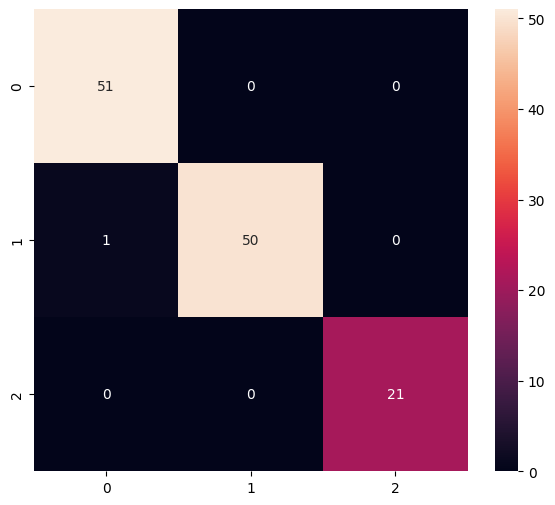

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       1.00      0.98      0.99        51
           2       1.00      1.00      1.00        21

    accuracy                           0.99       123
   macro avg       0.99      0.99      0.99       123
weighted avg       0.99      0.99      0.99       123



In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [15]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [16]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\TRUNGH~1\AppData\Local\Temp\tmp1nuun6q_\assets


6224